# **assignment 2**
### by group 13350742

In [1]:
# imports
import time 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.utils import resample
import warnings
from pprint import pprint
import optuna
warnings.filterwarnings("ignore")
%matplotlib inline

tasks:
- implement a nonlinear kernel classification based on SVM for polynomial kernels (poly) and for Gaussian Kernels, i.e., radial base functions (RBF)
- apply the analysis to a database of your choice, using the python code as provided (or your own)
- choose (and justify in a small text paragraph) two metrics to optimize for, such as accuracy, precision, recall, f1, f0.5, and f2 score, and determine which combo of hyperparameters maximizes each of the two scores you chose
- it would be on you if you want to use GridSearch (as used in the provided code), RandomSearch, or other methods such as hyperopt
- it is also on you to try other kernels of your choice
- a 2-hyperparameter scan is sufficient
- of course, you are free to scan more parameters, if useful and interesting and doable for you
- do not forget to comment your choices and results in short take-home statements

## data: banknote authentication

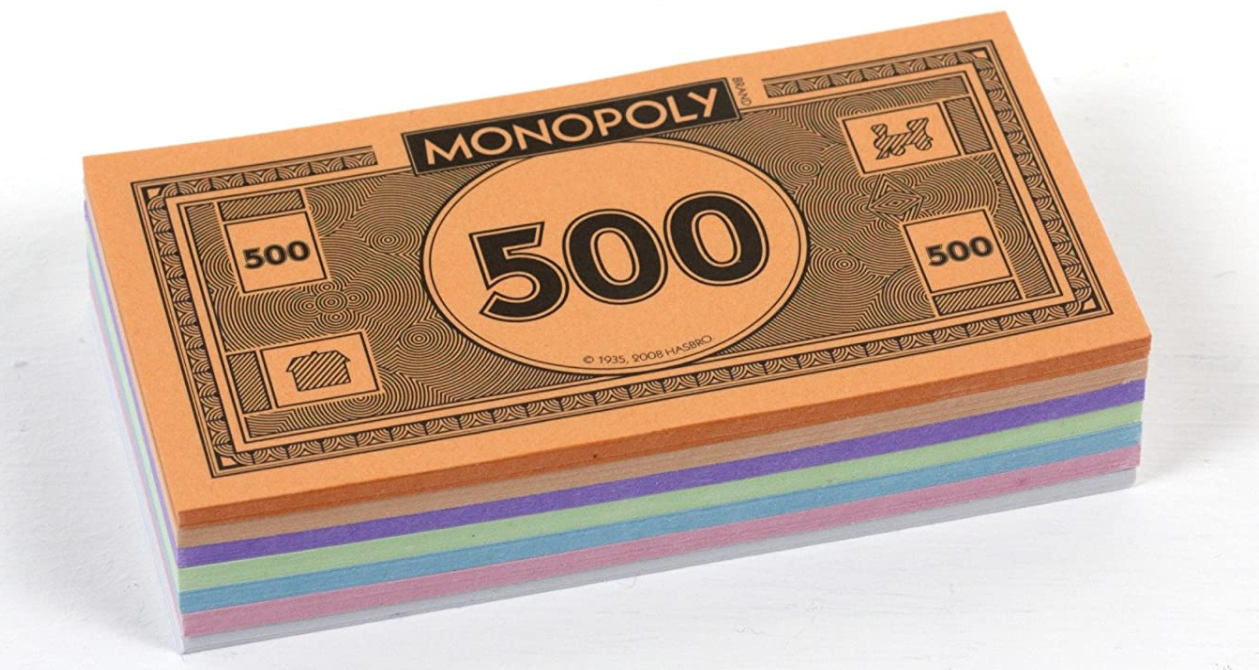

- the [data](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) (1.372 instances) was  extracted from images that were taken from genuine and forged banknote-like specimens 
- for digitization, an industrial camera usually used for print inspection was used 
- the final images have 400x400 pixels
- due to the object lens and distance to the investigated object, gray-scale pictures with a resolution of about 660 dpi were gained
- wavelet transform (image compression tool) was used to extract the following features from the images:
    - variance
    - skewness
    - kurtosis
    - entropy
    - class:0 (authentic), 1 (forgery)

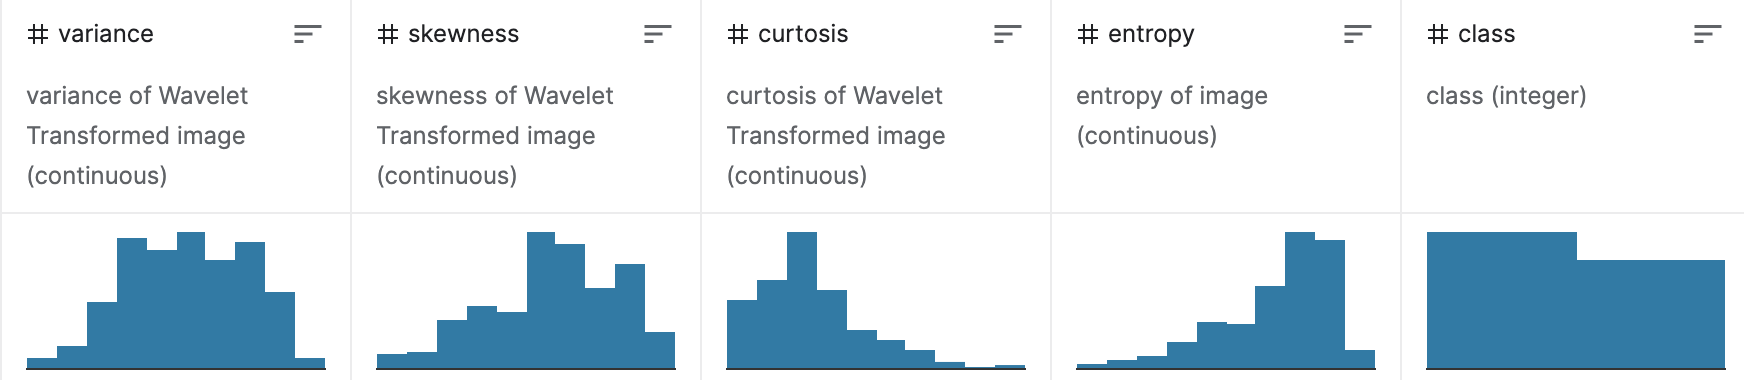

In [2]:
# loading data
df = pd.read_csv('BankNote_Authentication.csv', names=['variance','skewness','kurtosis','entropy','class'])
df.head(5)

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


let's look at how much real (0) and forged (1) banknotes are in the data set ...

In [3]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [4]:
# calculating ratio of forged banknotes
forge_ratio = round((df["class"][df["class"] == 1].count()/len(df["class"]))*100, 2)
print(f"the ratio of forged banknotes in the data is {forge_ratio}%")

the ratio of forged banknotes in the data is 44.46%


<div class="alert alert-success"> <b>takeaway</b>:
<br/>-positive and negative classes are relatively balances 
</div>

#### EDA

let's see how the data is distributed pairwise ...

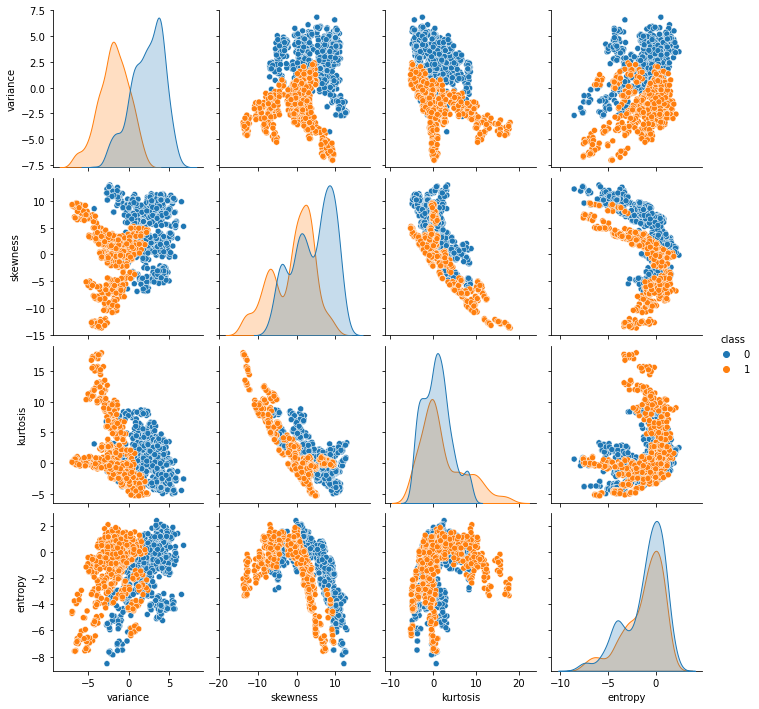

In [5]:
sns.pairplot(df, hue="class")

<div class="alert alert-success"> <b>takeaway</b>:
<br/>-basic pairplots show that positive and negative class has distictive variance and skewness
<br/>-the 2-dimensional representations often seem shifted to some degree across classes    
</div>

we can also explore the data by transforming it from 4 dimensions into 3 dimensions , which we naturally can interpret better, by using PCA ...

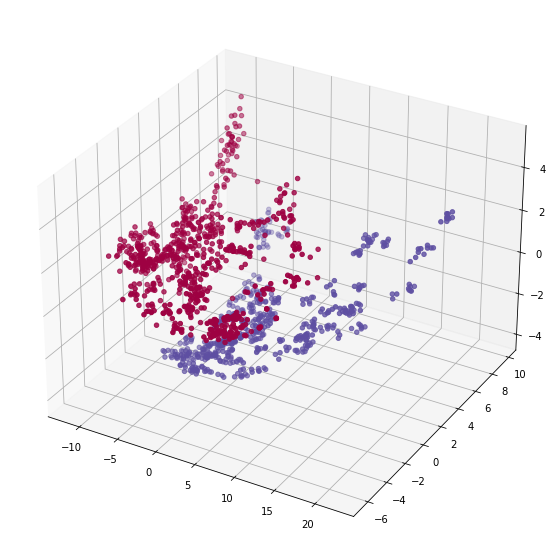

In [6]:
# splitting features and labels
X = df[["variance", "skewness", "kurtosis", "entropy"]]
y = df["class"]

# instantiating PCA
pca = PCA(n_components=3)
Y = pca.fit_transform(X)

# plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=y, cmap=plt.cm.Spectral)
ax.axis('tight')
plt.show()

<div class="alert alert-success"> <b>takeaway</b>:
<br/>-just by looking at the first 3 principal components without the application of a kernel function the data already seems to be easily seperable
</div>

we use t-SNE to bring to create a 1-dimensional representation of the data ...  

Text(0.5, 1.0, '1 Feature')

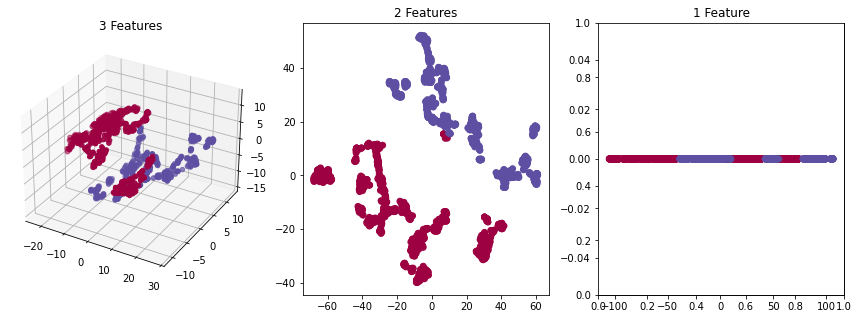

In [7]:
# application of t-SNE and plotting
fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

# 3d
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
PCA_3 = tsne.fit_transform(X)
ax1 = plt.subplot(131, projection="3d")
ax1.scatter(PCA_3[:, 0], PCA_3[:, 1], PCA_3[:, 2], c=y, cmap=plt.cm.Spectral)
ax1.set_title('3 Features')

# 2d
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
PCA_2 = tsne.fit_transform(X)
ax2 = plt.subplot(132)
ax2.scatter(PCA_2[:, 0],PCA_2[:, 1], c=y, cmap=plt.cm.Spectral)
ax2.set_title('2 Features')

# 1d
tsne = manifold.TSNE(n_components=1, init='pca', random_state=0)
PCA_1 = tsne.fit_transform(X)
ax3 = fig.add_subplot(133)
ax3.scatter(PCA_1[:, 0],np.zeros_like(PCA_1), c=y, cmap=plt.cm.Spectral)
ax3.set_title('1 Feature')

<div class="alert alert-success"> <b>takeaway</b>:
<br/>-clear visual and intuitive separability is remained to a high degree even in the 2-dimensional space
<br/>-this might be good news for a successful application of an SVM classifier if seperability is already yielded when using dimensionality reduction algorithms
</div>

## SVM classifier

### evaluation metric selection: $F_{\beta = 2}$ and $F_{\beta = 1}$

possible metrics that can be optimized in the analysis include accuracy, precision, recall as well as different variations of the F$\beta$-score 

in this specific case of banknote forgery, we can assume that both unidentified forged banknotes, $\textit{false negatives (FNs)}$, and real banknotes identified as forged ones, $\textit{false positives (FPs)}$, play an important role as they come with costs in the form of inconveniences like unfounded accusations (for $\textit{FPs}$) and forged money in circulation (for $\textit{FNs}$)

as we want to take into account FPs and FNs we can utilize

- $recall = \frac{TPs}{TPs + FNs}$ taking into account $\textit{FNs}$ 
- $precision = \frac{TPs}{TPs + FPs}$ taking into account $\textit{FPs}$ 

since the cost of not identifying forged banknotes ($\textit{FNs}$) and keeping counterfeit money in circulation for the future presumably is higher than identifying real banknotes as forged ($\textit{FP}$) we might also want to take a more specific look at keeping down $\textit{FNs}$

<div class="alert alert-success"> <b>takeaway</b>:
<br/>-we use the $F_{\beta} = (1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall}$ in order to take into account both $\textit{FPs}$ and $\textit{FNs}$ via  $\textit{precision}$ and $\textit{recall}$, respectively
<br/>-as we identified $\textit{FNs}$ to come with (presumably) higher costs, we not only use the $F_{\beta = 1}$ which assigns equal weights to $\textit{recall}$ and $\textit{precision}$ but also look at $F_{\beta = 2}$ that places more emphasis on the $\textit{recall}$ and thus $\textit{FNs}$   
</div>

defining the respective metric function (no need to define a scorer for $F_{\beta = 1}$ as it can be called directly in scikit-learn)  ...

In [8]:
# defining F2 scoring function
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

# wrapping scoring function for use in grid searches etc.
f2 = make_scorer(f2_scorer, greater_is_better=True)

splitting & scaling the data ...

In [9]:
# splitting into train and test set and 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
sc = StandardScaler()

# removing the mean and scaling the data to unit variance
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### polynomial vs. RBF kernels: comparing validation curves

#### polynomial kernel

defining a function to plot the respective metrics on the basis of the polynomial kernel ...

In [10]:
# defining function with default values gamma = "auto", C = 1, degree = 3
def plot_poly_curve(gammas = "auto", Cs = 1, degrees = 3, scoring = f2):
    
    num_splits = 5 
    kfold = KFold(n_splits = 5) 
    
    if type(degrees) == np.ndarray:
        svm_poly = svm.SVC(kernel = "poly", gamma = gammas, C = Cs)
        num_values = len(degrees)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name = "degree", param_range = degrees, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "degree"
        xtick = np.arange(degrees.min(), degrees.max(), 1)
        Xs = degrees
        ylim = [0.45, 1]
        
    elif type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = "poly", gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name = "C", param_range = Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "C"
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.98, 1]
        
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = "poly", degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name = "gamma", param_range = gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "gamma"
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.98, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = "training")
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = "test")
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel("f2")
    elif scoring == "f1":
        plt.ylabel("f1")
    else:
        plt.ylabel("scoring")
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title("SVM with polynomial kernel")
    plt.legend()

default parameters (constant if not changed on x-axis): gamma = "auto", C = 1 and degree = 3 ...

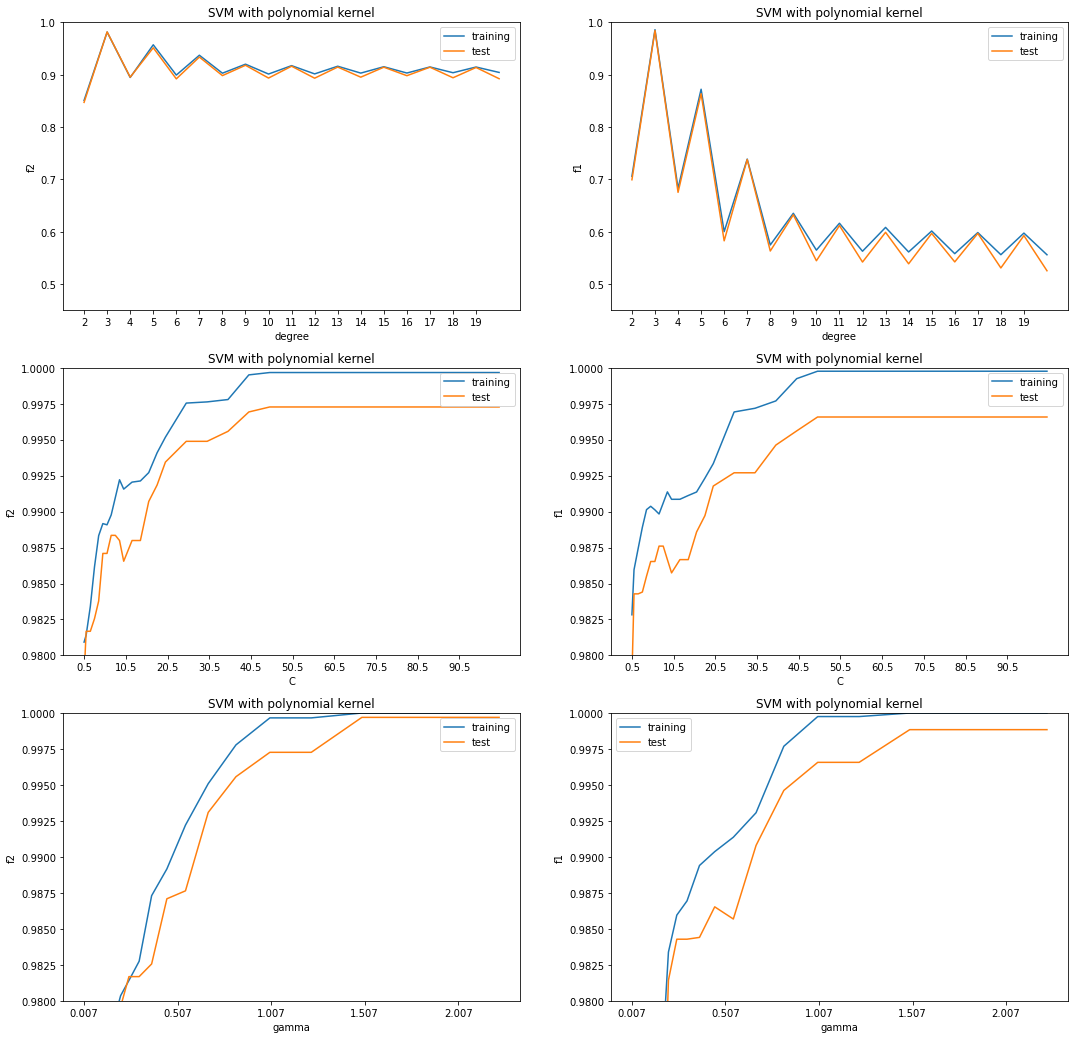

time spent: 12.40532660484314


In [11]:
start = time.time()

# plotting 
plt.figure(figsize = (18, 18))
degrees = np.arange(2, 21, 1) # choose/scan more systematically 
Cs = np.append(np.array([0.5]), np.append(np.append(np.arange(1, 10, 1), np.arange(10, 20, 2)), np.arange(20, 101, 5)))
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(3, 2, 1)
plot_poly_curve(degrees = degrees)
plt.subplot(3, 2, 2)
plot_poly_curve(degrees = degrees, scoring = "f1")
plt.subplot(3, 2, 3)
plot_poly_curve(Cs = Cs)
plt.subplot(3, 2, 4)
plot_poly_curve(Cs = Cs, scoring = "f1")
plt.subplot(3, 2, 5)
plot_poly_curve(gammas = gammas)
plt.subplot(3, 2, 6)
plot_poly_curve(gammas = gammas, scoring = "f1")

plt.show()

time_spent = time.time() - start
print(f"time spent: {time_spent}")

<div class="alert alert-success"> <b>takeaway: polynomial</b>:
<br/>-odd degrees prove to be beneficial for both $F_{\beta = 2}$ and $F_{\beta = 1}$
<br/>-the $F_{\beta = 1}$ decreases significantly with increasing degrees, as the precision is dragging the score down
<br/>-overfitting does not seem to play a major role as differences in training and test scores remain small
</div>

**Plot RBF Curve**

In [12]:
def plot_rbf_curve(gammas = "auto", Cs = 1, scoring = f2): 
    
    num_splits = 5 
    kfold = KFold(n_splits = 5)
    
    if type(Cs) == np.ndarray:
        svm_rbf = svm.SVC(kernel = "rbf", gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_rbf, X_train, y_train, 
                                                  param_name = "C", param_range = Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "C"
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.98, 1]
        
    elif type(gammas) == np.ndarray:
        svm_rbf = svm.SVC(kernel = "rbf", C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_rbf, X_train, y_train, 
                                                  param_name = "gamma", param_range = gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "gamma"
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.98, 1]
        
    else:
        raise TypeError

    train_scores_rbf = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_rbf = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_rbf.mean(axis=1), label = "training")
    plt.plot(Xs, valid_scores_rbf.mean(axis=1), label = "test")
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel("f2")
    elif scoring == "f1":
        plt.ylabel("f1")
    else:
        plt.ylabel("scoring")
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title("SVM with RBF kernel")
    plt.legend()  

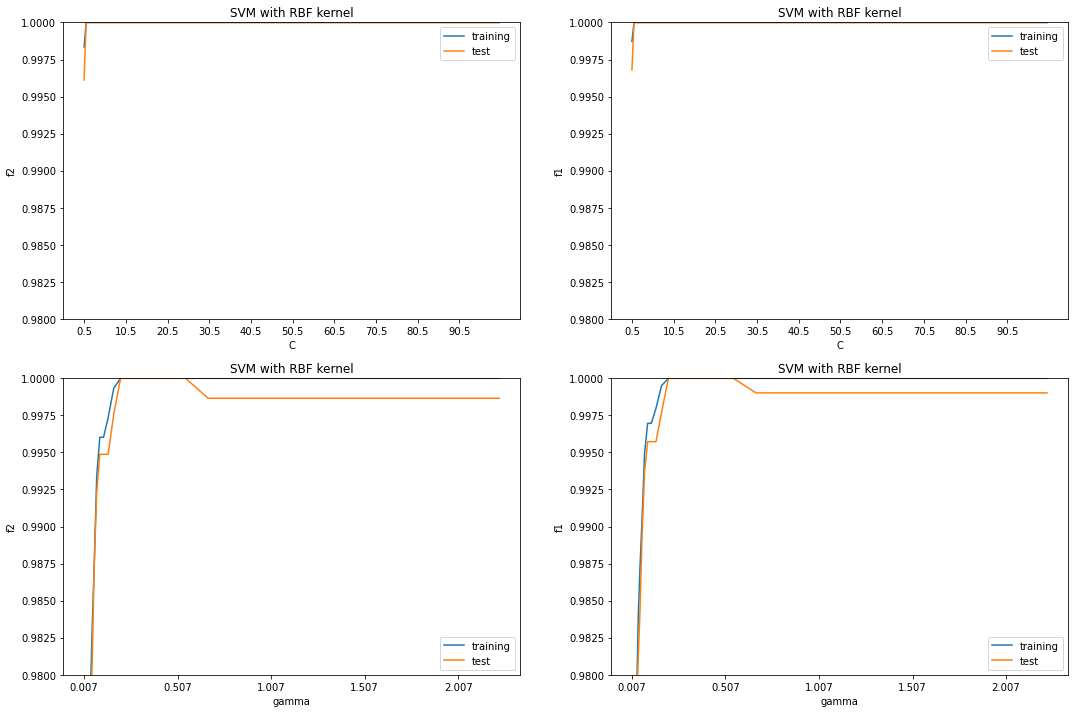

time spent: 5.844944000244141


In [13]:
start = time.time()

plt.figure(figsize = (18, 12))
plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = "f1")
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = "f1")
plt.show()

time_spent = time.time() - start
print(f"time spent: {time_spent}")

<div class="alert alert-success"> <b>takeaway: RBF</b>:
<br/>-the mere apllication of RBF seem to work extraordinarily well as $F_{\beta = 2}$ and $F_{\beta = 1}$ scores are close to 1 regardless of the hyperparameter combinations
<br/>-from eyeballing the scores, hyperparameter combinations with perfect training and test $F_{\beta = 2}$ and $F_{\beta = 1}$ scores can be identified
<br/>-increasing $\gamma$s seem to cause hints of overfitting
</div>

<div class="alert alert-success"> <b>takeaway: polynomial vs. RBF</b>:
<br/>-overall, we see that the underlying data is well-suited for SVMs as most scores are above 90% across different hyperparameters 
<br/>-using RBF results in almost perfect scores from the get-go with arbitrarily chosen default hyperparameters
</div>

### hyperparameter tuning using grid search and randomized grid search

for convenience the (randomized) grid searches are circumvented if their respective results are already available as CSV files

#### grid search

- we ran 2 grid searches
- although both achieved nearly perfect scores, the combinations of the hyperparameters show some differences, enabling us to gain some insights by visualizing them using heatmaps

#### *first grid search*

In [14]:
# if the grid search's results are already available we can load it
try:
    df_1 = pd.read_csv("GS_1_results_sorted_f1",delimiter = ",")
    df_2 = pd.read_csv("GS_1_results_sorted_f2",delimiter = ",")
# otherwise it needs to be carried out    
except:
    # first grid search  
    start = time()

    param_grid = {'kernel' : ['poly', 'rbf'],
                  'C' : [0.1, 1, 10, 50, 100],
                  'gamma' : [1/X_train.shape[1], 0.001, 0.01, 0.1, 1, 2],
                  'degree' : [2, 3, 4]}     

    scoring = {'Accuracy' : 'accuracy',
               'Precision' : 'precision',  
               'recall' : 'recall',
               'f1' : 'f1', 
               'f2' : f2}

    svm_svc = svm.SVC() #random_state = 0)
    CV_svm = GridSearchCV(estimator = svm_svc, param_grid = param_grid, cv = 5, 
                          scoring = scoring, refit = 'f2')
    CV_svm.fit(X_train, y_train)

    time_spend = time() - start
    print('time spent: ', time_spend)
    
    # record results
    params_ = CV_svm.cv_results_['params']
    result = {k : [dic[k] for dic in params_] for k in params_[0]}

    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2']:
        result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
        result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
        cln.append('mean_test_' + i)

    results_1 = pd.DataFrame(result)

    # process irelevant parameters 
    results_1.loc[results_1.kernel == 'linear', ['degree', 'gamma']] = np.nan 
    results_1.loc[results_1.kernel == 'rbf', 'degree'] = np.nan  
    results_1.drop_duplicates(inplace = True) 

    # sort by F1
    results_1_sorted_f1 = results_1.sort_values('mean_test_f1', ascending = False) 
    results_1_sorted_f1.drop_duplicates(subset = results_1_sorted_f1.columns[3:], inplace = True) 
    results_1_sorted_f1.loc[:,cln].to_csv("GS_1_results_sorted_f1", index=False) ######### Save sorted(f1) results to csv
    display(results_1_sorted_f1.loc[:,cln].head(10))

    # sort by F2
    results_1_sorted_f2 = results_1.sort_values('mean_test_f2', ascending = False) 
    results_1_sorted_f2.drop_duplicates(subset = results_1_sorted_f2.columns[3:], inplace = True) 
    results_1_sorted_f2.loc[:,cln].to_csv("GS_1_results_sorted_f2", index=False) ######### Save sorted(f2) results to csv
    display(results_1_sorted_f2.loc[:,cln].head(10))

In [15]:
# displaying results
cln = ['kernel', 'C', 'gamma', 'degree']
display(df_1.head(10))
display(df_2.head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,100.0,0.10,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,rbf,1.0,1.00,NaN,0.999091,0.998000,1.000000,0.998995,0.998675
2,rbf,50.0,0.01,NaN,0.999087,0.997980,1.000000,0.998985,0.998675
3,poly,1.0,2.00,3.0,0.999087,1.000000,0.997959,0.998974,0.999670
4,poly,100.0,0.25,3.0,0.998174,1.000000,0.995918,0.997938,0.999341
5,poly,0.1,2.00,3.0,0.997260,0.995939,0.997959,0.996944,0.997023
6,poly,1.0,1.00,3.0,0.997260,0.997980,0.995918,0.996923,0.998017
7,rbf,1.0,0.10,NaN,0.996351,0.991980,1.000000,0.995960,0.994698
8,rbf,0.1,2.00,NaN,0.995442,0.989980,1.000000,0.994955,0.993373
9,rbf,0.1,0.25,NaN,0.988144,0.974600,1.000000,0.987044,0.982693


,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,1.0,0.25,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,poly,10.0,2.00,3.0,0.999087,1.000000,0.997959,0.998974,0.999670
2,poly,100.0,0.25,3.0,0.998174,1.000000,0.995918,0.997938,0.999341
3,rbf,10.0,2.00,NaN,0.999091,0.998000,1.000000,0.998995,0.998675
4,rbf,50.0,0.01,NaN,0.999087,0.997980,1.000000,0.998985,0.998675
5,poly,1.0,1.00,3.0,0.997260,0.997980,0.995918,0.996923,0.998017
6,poly,0.1,2.00,3.0,0.997260,0.995939,0.997959,0.996944,0.997023
7,rbf,1.0,0.10,NaN,0.996351,0.991980,1.000000,0.995960,0.994698
8,rbf,0.1,2.00,NaN,0.995442,0.989980,1.000000,0.994955,0.993373
9,poly,10.0,0.25,3.0,0.988153,0.982076,0.991857,0.986903,0.986737


<div class="alert alert-success"> <b>takeaway: </b>:
<br/>-overall, we yield extremely accurate models
<br/>-surprisingly, the results are almost perfect across varying kernels, $C$ (factor of 1000) and $\gamma$ (factor of 20)  
</div>

#### *second grid search*

In [16]:
# if the grid search's results are already available we can load it
try:
    df_3 = pd.read_csv("GS_2_results_sorted_f1",delimiter = ",")
    df_4 = pd.read_csv("GS_2_results_sorted_f2",delimiter = ",")
# otherwise it needs to be carried out    
except:
    # second grid search
    start = time()

    param_grid = {'kernel' : ['poly', 'rbf'],
                  'C' : [0.1, 1, 10, 50, 100, 150],
                  'gamma' : [1/X_train.shape[1], 0.001, 0.01, 0.1, 1, 2],
                  'degree' : [2, 3, 4, 5]}             

    scoring = {'Accuracy' : 'accuracy',
               'Precision' : 'precision',  
               'recall' : 'recall',
               'f1' : 'f1', 
               'f2' : f2}

    svm_svc = svm.SVC() #random_state = 0)
    CV_svm_2 = GridSearchCV(estimator = svm_svc, param_grid = param_grid, cv = 5, 
                          scoring = scoring, refit = 'f2')
    CV_svm_2.fit(X_train, y_train)

    time_spend = time() - start
    print('time spent: ', time_spend)
    
    # record results
    params_ = CV_svm_2.cv_results_['params']
    result = {k : [dic[k] for dic in params_] for k in params_[0]}
    cln = ['kernel', 'C', 'gamma', 'degree']

    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2']:
        result['mean_test_' + i] = CV_svm_2.cv_results_['mean_test_' + i]
        result['std_test_' + i] = CV_svm_2.cv_results_['std_test_' + i]
        cln.append('mean_test_' + i)

    results_2 = pd.DataFrame(result)
    
    # process irelevant parameters
    results_2.loc[results_2.kernel == 'linear', ['degree', 'gamma']] = np.nan 
    results_2.loc[results_2.kernel == 'rbf', 'degree'] = np.nan 
    results_2.drop_duplicates(inplace = True) 

    # sort by F1
    results_2_sorted_f1 = results_2.sort_values('mean_test_f1', ascending = False) 
    results_2_sorted_f1.drop_duplicates(subset = results_2_sorted_f1.columns[3:], inplace = True) 
    results_2_sorted_f1.loc[:,cln].to_csv("GS_2_results_sorted_f1", index=False) ######### Save sorted(f1) results to csv

    # sort by F2
    results_2_sorted_f2 = results_2.sort_values('mean_test_f2', ascending = False) 
    results_2_sorted_f2.drop_duplicates(subset = results_2_sorted_f2.columns[3:], inplace = True) 
    results_2_sorted_f2.loc[:,cln].to_csv("GS_2_results_sorted_f2", index=False) ######### Save sorted(f2) results to csv
    
    

In [17]:
# displaying results
display(df_3.head(10))
display(df_4.head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,10.0,0.25,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,rbf,150.0,2.00,NaN,0.999091,0.998000,1.000000,0.998995,0.998675
2,rbf,50.0,0.01,NaN,0.999087,0.997980,1.000000,0.998985,0.998675
3,poly,100.0,1.00,3.0,0.999087,1.000000,0.997959,0.998974,0.999670
4,poly,100.0,0.25,3.0,0.998174,1.000000,0.995918,0.997938,0.999341
5,poly,0.1,2.00,3.0,0.997260,0.995939,0.997959,0.996944,0.997023
6,poly,1.0,1.00,3.0,0.997260,0.997980,0.995918,0.996923,0.998017
7,rbf,1.0,0.10,NaN,0.996351,0.991980,1.000000,0.995960,0.994698
8,rbf,0.1,2.00,NaN,0.995442,0.989980,1.000000,0.994955,0.993373
9,poly,1.0,2.00,5.0,0.995455,0.993999,0.995960,0.994954,0.995366


,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,100.0,0.10,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,poly,150.0,2.00,3.0,0.999087,1.000000,0.997959,0.998974,0.999670
2,poly,100.0,0.25,3.0,0.998174,1.000000,0.995918,0.997938,0.999341
3,rbf,100.0,2.00,NaN,0.999091,0.998000,1.000000,0.998995,0.998675
4,rbf,50.0,0.01,NaN,0.999087,0.997980,1.000000,0.998985,0.998675
5,poly,1.0,1.00,3.0,0.997260,0.997980,0.995918,0.996923,0.998017
6,poly,0.1,2.00,5.0,0.995446,0.997980,0.991878,0.994913,0.997357
7,poly,50.0,0.25,3.0,0.997260,0.995939,0.997959,0.996944,0.997023
8,poly,50.0,1.00,5.0,0.995455,0.993999,0.995960,0.994954,0.995366
9,poly,10.0,1.00,5.0,0.994541,0.993999,0.993919,0.993929,0.995036


<div class="alert alert-success"> <b>takeaway: </b>:
<br/>-again, we yield extremely accurate models
<br/>-surprisingly, the results are almost perfect across varying kernels, $C$ (factor of 1500) and $\gamma$ (factor of 20)  
</div>

#### *RBF-only grid search*

In [18]:
# if the grid search's results are already available we can load it
try:
    df_5 = pd.read_csv("GS_rbf_results_sorted_f1",delimiter = ",")
    df_6 = pd.read_csv("GS_rbf_results_sorted_f2",delimiter = ",")
# otherwise it needs to be carried out    
except:
    # RBF-only grid search
    start = time()

    C3 = np.append(np.array([1]), 
                   np.append(np.append(np.arange(0, 51, 1), 
                                       np.arange(51, 101, 5)), 
                                       np.arange(101, 201, 10)))

    param_grid3 = {'C' : C3,
                   'gamma' : np.append(np.arange(0.01, 3, 0.01), 1/X_train.shape[1])}   

    svm_svc = svm.SVC(kernel = 'rbf', random_state = 0)
    CV_svm_3 = GridSearchCV(estimator = svm_svc, param_grid = param_grid3, cv = 5, 
                            scoring = scoring, refit = 'f2')
    CV_svm_3.fit(X_train, y_train)

    time_spend = time() - start
    print('time spent: ', time_spend)
    
    # record results
    params_ = CV_svm_3.cv_results_['params']
    result = {k : [dic[k] for dic in params_] for k in params_[0]}

    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2']:
        result['mean_test_' + i] = CV_svm_3.cv_results_['mean_test_' + i]
        result['std_test_' + i] = CV_svm_3.cv_results_['std_test_' + i]

    results_3 = pd.DataFrame(result)
    results_3.loc[:, 'kernel'] = 'rbf' ######## Create kernel column, all='rbf'
    kernel = results_3['kernel'] ######## Move 'kernel' column to the front
    results_3.drop(labels=['kernel'], axis=1,inplace = True)
    results_3.insert(0, 'kernel', kernel)

    # process irelevant parameters
    results_3.loc[results_3.kernel == 'rbf', 'degree'] = np.nan 
    results_3.drop_duplicates(inplace = True) 

    # sort by F1
    results_3_sorted_f1 = results_3.sort_values('mean_test_f1', ascending = False) 
    results_3_sorted_f1.drop_duplicates(subset = results_3_sorted_f1.columns[3:], inplace = True) 
    results_3_sorted_f1.loc[:,cln].to_csv("GS_rbf_results_sorted_f1", index=False) ######### Save sorted(f1) results to csv

    # sort by F2
    results_3_sorted_f2 = results_3.sort_values('mean_test_f2', ascending = False) 
    results_3_sorted_f2.drop_duplicates(subset = results_3_sorted_f2.columns[3:], inplace = True) 
    results_3_sorted_f2.loc[:,cln].to_csv("GS_rbf_results_sorted_f2", index=False) ####### Save sorted(f2) results to csv

In [19]:
# displaying results
display(df_5.head(10))
display(df_6.head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,36,0.01,NaN,1.000000,1.00000,1.0,1.000000,1.000000
1,rbf,51,1.71,NaN,0.999091,0.99800,1.0,0.998995,0.998675
2,rbf,51,0.01,NaN,0.999087,0.99798,1.0,0.998985,0.998675
3,rbf,1,0.18,NaN,0.998174,0.99600,1.0,0.997980,0.997347
4,rbf,13,0.02,NaN,0.998178,0.99598,1.0,0.997980,0.997351
5,rbf,56,0.01,NaN,0.998178,0.99598,1.0,0.997980,0.997351
6,rbf,5,0.04,NaN,0.997264,0.99400,1.0,0.996975,0.996022
7,rbf,7,0.03,NaN,0.997260,0.99398,1.0,0.996965,0.996022
8,rbf,33,0.01,NaN,0.996355,0.99204,1.0,0.995980,0.994693
9,rbf,1,0.11,NaN,0.996351,0.99198,1.0,0.995960,0.994698


,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,36,0.01,NaN,1.000000,1.00000,1.0,1.000000,1.000000
1,rbf,51,1.72,NaN,0.999091,0.99800,1.0,0.998995,0.998675
2,rbf,8,0.03,NaN,0.999087,0.99798,1.0,0.998985,0.998675
3,rbf,34,0.01,NaN,0.998178,0.99598,1.0,0.997980,0.997351
4,rbf,61,0.01,NaN,0.998178,0.99598,1.0,0.997980,0.997351
5,rbf,2,0.09,NaN,0.998174,0.99600,1.0,0.997980,0.997347
6,rbf,7,0.03,NaN,0.997260,0.99398,1.0,0.996965,0.996022
7,rbf,5,0.04,NaN,0.997264,0.99400,1.0,0.996975,0.996022
8,rbf,1,0.10,NaN,0.996351,0.99198,1.0,0.995960,0.994698
9,rbf,33,0.01,NaN,0.996355,0.99204,1.0,0.995980,0.994693


<div class="alert alert-success"> <b>takeaway: </b>:
<br/>-again, we yield extremely accurate models
<br/>-surprisingly, the results are almost perfect across$C$ (factor of 51) and $\gamma$ (factor of 171)  
</div>

#### *polynomial-only grid search*

In [20]:
# if the grid search's results are already available we can load it
try:
    df_7 = pd.read_csv("GS_poly_results_sorted_f1",delimiter = ",")
    df_8 = pd.read_csv("GS_poly_results_sorted_f2",delimiter = ",")
# otherwise it needs to be carried out    
except:
    # polynomial-only grid search
    start = time()

    C4 = np.append(np.array([1]), 
                   np.append(np.append(np.arange(50, 71, 2), 
                                       np.arange(71, 151, 5)), 
                                       np.arange(151, 301, 10)))

    param_grid4 = {'C' : C4,
                  'gamma' : np.append(np.arange(2, 5, 0.01), 1/X_train.shape[1]),
                  'degree' : [3]}  

    svm_svc = svm.SVC(kernel = 'poly', random_state = 0)
    CV_svm_4 = GridSearchCV(estimator = svm_svc, param_grid = param_grid4, cv = 5, 
                            scoring = scoring, refit = 'f2')
    CV_svm_4.fit(X_train, y_train)

    time_spend = time() - start
    print('time spent: ', time_spend)

    # record results
    params_ = CV_svm_4.cv_results_['params']
    result = {k : [dic[k] for dic in params_] for k in params_[0]}

    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2']:
        result['mean_test_' + i] = CV_svm_4.cv_results_['mean_test_' + i]
        result['std_test_' + i] = CV_svm_4.cv_results_['std_test_' + i]

    results_4 = pd.DataFrame(result)
    results_4.loc[:, 'kernel'] = 'polynomial' ######## Create kernel column, all='polynomial'
    kernel = results_4['kernel'] ######## Move 'kernel' column to the front
    results_4.drop(labels=['kernel'], axis=1,inplace = True)
    results_4.insert(0, 'kernel', kernel)

    # process irelevant parameters
    results_4.drop_duplicates(inplace = True) 

    # sort by F1
    results_4_sorted_f1 = results_4.sort_values('mean_test_f1', ascending = False) 
    results_4_sorted_f1.drop_duplicates(subset = results_4_sorted_f1.columns[3:], inplace = True) 
    results_4_sorted_f1.loc[:,cln].to_csv("GS_poly_results_sorted_f1", index=False) ###### Save sorted(f1) results to csv

    # sort by F2
    results_4_sorted_f2 = results_4.sort_values('mean_test_f2', ascending = False) 
    results_4_sorted_f2.drop_duplicates(subset = results_4_sorted_f2.columns[3:], inplace = True) 
    results_4_sorted_f2.loc[:,cln].to_csv("GS_poly_results_sorted_f2", index=False) ###### Save sorted(f2) results to csv

In [21]:
# displaying results
display(df_7.head(10))
display(df_8.head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,polynomial,1,2.00,3,0.999087,1.0,0.997959,0.998974,0.99967
1,polynomial,151,4.04,3,0.999087,1.0,0.997959,0.998974,0.99967
2,polynomial,151,3.94,3,0.999087,1.0,0.997959,0.998974,0.99967
3,polynomial,151,3.95,3,0.999087,1.0,0.997959,0.998974,0.99967
4,polynomial,151,3.96,3,0.999087,1.0,0.997959,0.998974,0.99967
5,polynomial,151,3.97,3,0.999087,1.0,0.997959,0.998974,0.99967
6,polynomial,151,3.98,3,0.999087,1.0,0.997959,0.998974,0.99967
7,polynomial,151,3.99,3,0.999087,1.0,0.997959,0.998974,0.99967
8,polynomial,151,4.00,3,0.999087,1.0,0.997959,0.998974,0.99967
9,polynomial,151,4.01,3,0.999087,1.0,0.997959,0.998974,0.99967


,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,polynomial,1,2.00,3,0.999087,1.0,0.997959,0.998974,0.99967
1,polynomial,151,4.04,3,0.999087,1.0,0.997959,0.998974,0.99967
2,polynomial,151,3.94,3,0.999087,1.0,0.997959,0.998974,0.99967
3,polynomial,151,3.95,3,0.999087,1.0,0.997959,0.998974,0.99967
4,polynomial,151,3.96,3,0.999087,1.0,0.997959,0.998974,0.99967
5,polynomial,151,3.97,3,0.999087,1.0,0.997959,0.998974,0.99967
6,polynomial,151,3.98,3,0.999087,1.0,0.997959,0.998974,0.99967
7,polynomial,151,3.99,3,0.999087,1.0,0.997959,0.998974,0.99967
8,polynomial,151,4.00,3,0.999087,1.0,0.997959,0.998974,0.99967
9,polynomial,151,4.01,3,0.999087,1.0,0.997959,0.998974,0.99967


<div class="alert alert-success"> <b>takeaway: </b>:
<br/>-again, we yield extremely accurate models
<br/>-surprisingly, the results are almost perfect across varying $C$ (factor of 151)
</div>

#### extra: randomized grid search

#### *RBF-only randomized grid search*

In [22]:
# if the randomized grid search's results are already available we can load it
try:
    df_9 = pd.read_csv("RS_rbf_results_sorted_f1",delimiter = ",")
    df_10 = pd.read_csv("RS_rbf_results_sorted_f2",delimiter = ",")
# otherwise it needs to be carried out    
except:
    # RBF-only randomized grid search
    start = time()

    C5 = np.append(np.array([0.1]), 
                   np.append(np.append(np.arange(0, 51, 0.1), 
                                       np.arange(51, 101, 0.1)), 
                                       np.arange(101, 201, 0.1)))

    param_grid5 = {'C' : C5,
                   'gamma' : np.append(np.arange(0.001, 3, 0.001), 1/X_train.shape[1])}   

    svm_svc = svm.SVC(kernel = 'rbf', random_state = 0)
    CV_svm_5 = RandomizedSearchCV(estimator = svm_svc, param_distributions = param_grid5, cv = 5, 
                                  scoring = scoring, refit = 'f2')
    CV_svm_5.fit(X_train, y_train)

    time_spend = time() - start
    print('time spent: ', time_spend)

    # record results
    params_ = CV_svm_5.cv_results_['params']
    result = {k : [dic[k] for dic in params_] for k in params_[0]}
    cln = ['kernel', 'C', 'gamma']

    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2']:
        result['mean_test_' + i] = CV_svm_5.cv_results_['mean_test_' + i]
        result['std_test_' + i] = CV_svm_5.cv_results_['std_test_' + i]
        cln.append('mean_test_' + i)

    results_5 = pd.DataFrame(result)
    results_5.loc[:, 'kernel'] = 'rbf' ######## Create kernel column, all='rbf'
    kernel = results_5['kernel'] ######## Move 'kernel' column to the front
    results_5.drop(labels=['kernel'], axis=1,inplace = True)
    results_5.insert(0, 'kernel', kernel)

    # process irelevant parameters
    results_3.loc[results_3.kernel == 'rbf', 'degree'] = np.nan 
    results_5.drop_duplicates(inplace = True) 

    # sort by F1
    results_5_sorted_f1 = results_5.sort_values('mean_test_f1', ascending = False) 
    results_5_sorted_f1.drop_duplicates(subset = results_5_sorted_f1.columns[3:], inplace = True) 
    results_5_sorted_f1.loc[:,cln].to_csv("RS_rbf_results_sorted_f1", index=False) ######### Save sorted(f1) results to csv
    display(results_5_sorted_f1.loc[:,cln].head(10))

    # sort by F2
    results_5_sorted_f2 = results_5.sort_values('mean_test_f2', ascending = False) 
    results_5_sorted_f2.drop_duplicates(subset = results_5_sorted_f2.columns[3:], inplace = True) 
    results_5_sorted_f2.loc[:,cln].to_csv("RS_rbf_results_sorted_f2", index=False) ####### Save sorted(f2) results to csv
    display(results_5_sorted_f2.loc[:,cln].head(10))

In [23]:
# displaying results
display(df_9.head(10))

,kernel,C,gamma,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,55.2,0.095,1.000000,1.000,1.0,1.000000,1.000000
1,rbf,13.1,1.065,0.999091,0.998,1.0,0.998995,0.998675


#### *polynomial-only randomized grid search*

In [24]:
# if the randomized grid search's results are already available we can load it
try:
    df_11 = pd.read_csv("RS_rbf_results_sorted_f1",delimiter = ",")
    df_12 = pd.read_csv("RS_rbf_results_sorted_f2",delimiter = ",")
# otherwise it needs to be carried out    
except:
    # polynomial-only randomized grid search
    start = time()

    C6 = np.append(np.array([1]), 
                   np.append(np.append(np.arange(0, 51, 1), 
                                       np.arange(51, 101, 1)), 
                                       np.arange(101, 201, 5)))

    param_grid6 = {'C' : C6,
                  'gamma' : np.append(np.arange(0, 5, 0.001), 1/X_train.shape[1]),
                  'degree' : [3]}  

    scoring = {'Accuracy' : 'accuracy',
               'Precision' : 'precision',  
               'recall' : 'recall',
               'f1' : 'f1', 
               'f2' : f2}

    svm_svc = svm.SVC(kernel = 'poly', random_state = 0)
    CV_svm_6 = RandomizedSearchCV(estimator = svm_svc, param_distributions = param_grid6, cv = 5, 
                                  scoring = scoring, refit = 'f2')
    CV_svm_6.fit(X_train, y_train)

    time_spend = time() - start
    print('time spent: ', time_spend)

    # record results
    params_ = CV_svm_6.cv_results_['params']
    result = {k : [dic[k] for dic in params_] for k in params_[0]}
    cln = ['kernel', 'C', 'gamma', 'degree']

    for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2']:
        result['mean_test_' + i] = CV_svm_6.cv_results_['mean_test_' + i]
        result['std_test_' + i] = CV_svm_6.cv_results_['std_test_' + i]
        cln.append('mean_test_' + i)

    results_6 = pd.DataFrame(result)
    results_6.loc[:, 'kernel'] = 'polynomial' ######## Create kernel column, all='polynomial'
    kernel = results_6['kernel'] ######## Move 'kernel' column to the front
    results_6.drop(labels=['kernel'], axis=1,inplace = True)
    results_6.insert(0, 'kernel', kernel)

    # process irelevant parameters
    results_6.drop_duplicates(inplace = True) 

    # sort by F1
    results_6_sorted_f1 = results_6.sort_values('mean_test_f1', ascending = False) 
    results_6_sorted_f1.drop_duplicates(subset = results_6_sorted_f1.columns[3:], inplace = True) 
    results_6_sorted_f1.loc[:,cln].to_csv("RS_poly_results_sorted_f1", index=False) ###### Save sorted(f1) results to csv

    # sort by F2
    results_6_sorted_f2 = results_6.sort_values('mean_test_f2', ascending = False) 
    results_6_sorted_f2.drop_duplicates(subset = results_6_sorted_f2.columns[3:], inplace = True) 
    results_6_sorted_f2.loc[:,cln].to_csv("RS_poly_results_sorted_f2", index=False) ###### Save sorted(f2) results to csv


In [25]:
# displaying results
display(df_11.head(10))

,kernel,C,gamma,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2
0,rbf,55.2,0.095,1.000000,1.000,1.0,1.000000,1.000000
1,rbf,13.1,1.065,0.999091,0.998,1.0,0.998995,0.998675


#### visualizing hyperparameter search results

looking at the RBF hyperparameter combinations and the respective scores


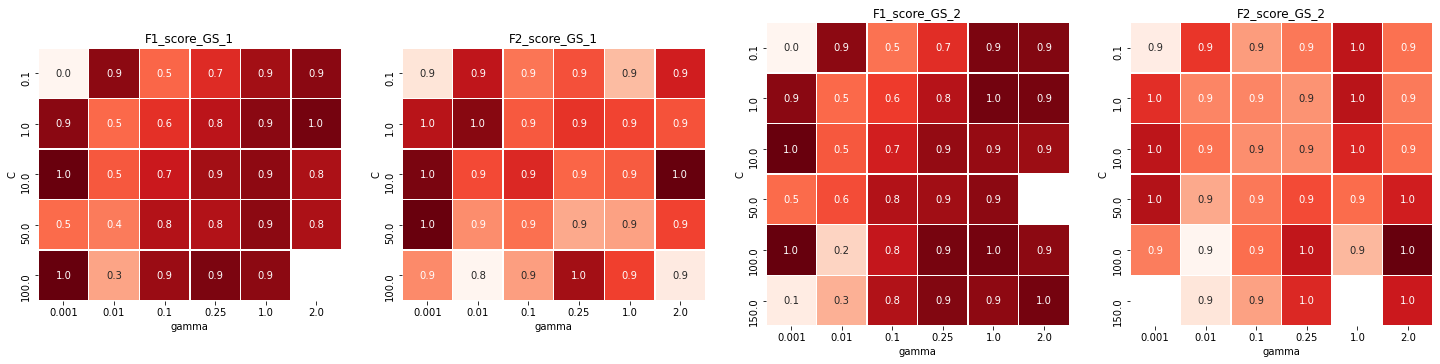

In [26]:
# plotting heatmap
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(25,25));

# mean_test_f1
sns_data = df_1[['C','gamma','mean_test_f1']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f1')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Reds',ax=axes[0],cbar=False)


sns_data = df_3[['C','gamma','mean_test_f1']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f1')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Reds',ax=axes[2],cbar=False)

# mean_test_f2
sns_data = df_2[['C','gamma','mean_test_f2']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f2')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Reds',ax=axes[1],cbar=False)

sns_data = df_4[['C','gamma','mean_test_f2']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f2')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Reds',ax=axes[3],cbar=False)

axes[0].title.set_text('F1_score_GS_1')
axes[1].title.set_text('F2_score_GS_1')
axes[2].title.set_text('F1_score_GS_2')
axes[3].title.set_text('F2_score_GS_2')

print("looking at the RBF hyperparameter combinations and the respective scores")

<div class="alert alert-success"> <b>takeaway: </b>:
<br/>-as previously shown the best $F_{\beta = 1}$ and  $F_{\beta = 2}$ scores are achieved when we use the RBF kernel 
<br/>-possible combination of the hyperparameters for a perfect $F_{\beta = 1}$ score (=1) are kernel: RBF, $C = 100$, $\gamma = 0.001$ and kernel: RBF, $C = 1$, $\gamma = 1$
<br/>-possible combination of the hyperparameters for a perfect  $F_{\beta = 2}$ are kernel: RBF, $C = 100$, $\gamma=0.25$ and kernel: RBF, $C = 1$, $\gamma=0.01$ 
</div>

#### confusion matrix for the best hyperparameters

In [27]:
# RBF kernel with the best combination to maximize F2 score
svm_bestf2 = svm.SVC(C = 36, gamma = 0.01,kernel = 'rbf')
svm_bestf2.fit(X_train, y_train)

y_train_pred = svm_bestf2.predict(X_train)
y_test_pred = svm_bestf2.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f2_train = f2_scorer(y_train, y_train_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('f2 score of training sample: ', f2_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of test sample: ', f2_test)

Confusion matrix of training sample: 
 [[605   0]
 [  0 492]]
f2 score of training sample:  1.0
Confusion matrix of test sample: 
 [[157   0]
 [  0 118]]
f2 score of test sample:  1.0


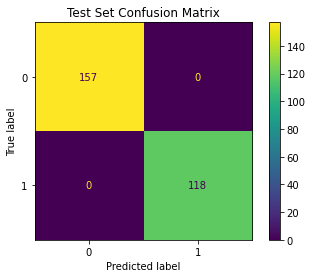

In [28]:
plot_confusion_matrix(svm_bestf2, X_test, y_test) 
plt.title('Test Set Confusion Matrix')
plt.show()

### extra: hyperparameter optimization using Optuna

results: 
- a hyperparameter combination found which gives the best $F_{\beta = 2}$ is kernel= RBF, $C = 8.89$ and $\gamma =0.05$
- a hyperparameter combination found which gives the best $F_{\beta = 1}$ is kernel= RBF, $C = 1.05$ and $\gamma = 8.19$

In [52]:
#Set aside the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

using Optuna to optimize $F_{\beta = 2}$ score for the polynomial kernel ...

In [53]:
def model_performance(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return f2_scorer(y, y_pred)

def create_model(trial):
    regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
    gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
    degree = trial.suggest_int('degree', 3, 5)
    model = svm.SVC(kernel="poly", C=regularization,gamma=gamma,degree=degree)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 15:23:54,073] A new study created in memory with name: no-name-56d3f163-56dd-4fa1-ae41-ce7587151487
[I 2021-04-27 15:23:54,092] Trial 0 finished with value: 0.9919839679358717 and parameters: {'svm-regularization': 6.296642117560029, 'svm-gamma': 0.5967856391384166, 'degree': 5}. Best is trial 0 with value: 0.9919839679358717.
[I 2021-04-27 15:23:54,105] Trial 1 finished with value: 0.9797979797979797 and parameters: {'svm-regularization': 3.9519467345590207, 'svm-gamma': 3.6276041461110378, 'degree': 5}. Best is trial 0 with value: 0.9919839679358717.
[I 2021-04-27 15:23:54,114] Trial 2 finished with value: 0.9959758551307847 and parameters: {'svm-regularization': 5.211439826795015, 'svm-gamma': 6.517592325031055, 'degree': 3}. Best is trial 2 with value: 0.9959758551307847.
[I 2021-04-27 15:23:54,129] Trial 3 finished with value: 0.9797979797979797 and parameters: {'svm-regularization': 6.809747726685861, 'svm-gamma': 5.583952524512083, 'degree': 5}. Best is trial 2 wit

In [55]:
trial = study.best_trial
print('F2: {}'.format(trial.value))
print("Best hyperparameters of svm_poly_kernel: {}".format(trial.params))

F2: 0.9959758551307847
Best hyperparameters of svm_poly_kernel: {'svm-regularization': 5.211439826795015, 'svm-gamma': 6.517592325031055, 'degree': 3}


using Optuna to optimize $F_{\beta = 2}$ score for the RBF kernel ...

In [56]:
def model_performance(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return f2_scorer(y, y_pred)

def create_model(trial):
    regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
    gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
    model = svm.SVC(kernel="rbf", C=regularization,gamma=gamma)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [57]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 15:24:41,830] A new study created in memory with name: no-name-55aaab9e-132c-43dc-a89c-6c0de95a9996
[I 2021-04-27 15:24:41,845] Trial 0 finished with value: 1.0 and parameters: {'svm-regularization': 4.59764314800049, 'svm-gamma': 3.7318111851964226}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,860] Trial 1 finished with value: 1.0 and parameters: {'svm-regularization': 2.309051569907934, 'svm-gamma': 6.61857981716482}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,881] Trial 2 finished with value: 1.0 and parameters: {'svm-regularization': 0.377624186460142, 'svm-gamma': 9.555586697755587}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,903] Trial 3 finished with value: 1.0 and parameters: {'svm-regularization': 3.3059353788791914, 'svm-gamma': 8.451567376701876}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,914] Trial 4 finished with value: 1.0 and parameters: {'svm-regularization': 5.648367981557028, 'svm-gamma': 3.860127538498

In [58]:
trial = study.best_trial
print('F2: {}'.format(trial.value))
print("Best hyperparameters of svm_rbf_kernel: {}".format(trial.params))

F2: 1.0
Best hyperparameters of svm_rbf_kernel: {'svm-regularization': 4.59764314800049, 'svm-gamma': 3.7318111851964226}


#### *RBF vs. polynomial kernel*

In [9]:
def model_performance(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return f2_scorer(y, y_pred)

def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['poly_svm', 'rbf_svm'])

    if model_type == 'poly_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        degree = trial.suggest_int('degree', 3, 5, 1)
        model = svm.SVC(kernel="poly", C=regularization,gamma=gamma,degree=degree)
        
        
    if model_type == 'rbf_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        model = svm.SVC(kernel='rbf', C=regularization, gamma=gamma)
        
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 11:24:43,079] A new study created in memory with name: no-name-c0450864-bf66-426d-a7b1-b60a01c66e89
[I 2021-04-27 11:24:43,090] Trial 0 finished with value: 1.0 and parameters: {'model_type': 'rbf_svm', 'svm-regularization': 8.896483763633299, 'svm-gamma': 0.05262273836649758}. Best is trial 0 with value: 1.0.
[I 2021-04-27 11:24:43,104] Trial 1 finished with value: 1.0 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 8.157609086762212, 'svm-gamma': 7.590886460519331, 'degree': 3}. Best is trial 0 with value: 1.0.
[I 2021-04-27 11:24:43,117] Trial 2 finished with value: 1.0 and parameters: {'model_type': 'rbf_svm', 'svm-regularization': 1.0736215399974398, 'svm-gamma': 2.613152682583091}. Best is trial 0 with value: 1.0.
[I 2021-04-27 11:24:43,131] Trial 3 finished with value: 1.0 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 2.4796518117537825, 'svm-gamma': 0.46389306077318454, 'degree': 3}. Best is trial 0 with value: 1.0.
[I 2021-04-2

In [11]:
trial = study.best_trial
print('F2: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F2: 1.0
Best hyperparameters: {'model_type': 'rbf_svm', 'svm-regularization': 8.896483763633299, 'svm-gamma': 0.05262273836649758}


In [60]:
def model_performance_f1(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return sklearn.metrics.f1_score(y, y_pred)

def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['poly_svm', 'rbf_svm'])

    if model_type == 'poly_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        degree = trial.suggest_int('degree', 3, 5, 1)
        model = svm.SVC(kernel="poly", C=regularization,gamma=gamma,degree=degree)
        
        
    if model_type == 'rbf_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        model = svm.SVC(kernel='rbf', C=regularization, gamma=gamma)
        
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance_f1(model)

In [61]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 15:35:12,149] A new study created in memory with name: no-name-72cbdedd-9a53-48fd-8e93-e3e6ba27f3df
[I 2021-04-27 15:35:12,168] Trial 0 finished with value: 0.9868421052631579 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 2.0003204208265584, 'svm-gamma': 7.758012742590255, 'degree': 3}. Best is trial 0 with value: 0.9868421052631579.
[I 2021-04-27 15:35:12,186] Trial 1 finished with value: 1.0 and parameters: {'model_type': 'rbf_svm', 'svm-regularization': 1.0470224477010572, 'svm-gamma': 8.195089703916686}. Best is trial 1 with value: 1.0.
[I 2021-04-27 15:35:12,199] Trial 2 finished with value: 0.974025974025974 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 8.985657042445544, 'svm-gamma': 2.09585827709021, 'degree': 5}. Best is trial 1 with value: 1.0.
[I 2021-04-27 15:41:18,765] Trial 3 finished with value: 0.9358974358974359 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 1.8691756813545182, 'svm-gamma': 7.7230979

In [62]:
trial = study.best_trial
print('F1: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F1: 1.0
Best hyperparameters: {'model_type': 'rbf_svm', 'svm-regularization': 1.0470224477010572, 'svm-gamma': 8.195089703916686}


In [13]:
# test the result on test set
svm_bestf2 = svm.SVC(C = 8.89, 
                     gamma = 0.05,
                     kernel = 'rbf')
    
svm_bestf2.fit(X_train, y_train)

y_test_pred = svm_bestf2.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_test_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of test sample: ', f2_test)

Confusion matrix of test sample: 
 [[157   0]
 [  0 118]]
f2 score of test sample:  1.0


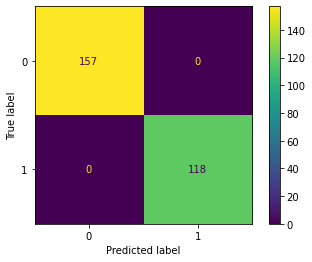

In [15]:
plot_confusion_matrix(svm_bestf2, X_test, y_test) 
plt.show()

<div class="alert alert-success"> <b>takeaway: </b>:
<br/>-using a different hyperparameter optimization approach, we , again, arrive at a perfect solution
</div>